In [1]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pymysql
import yfinance as yf
from helpers import *

cursor = get_cursor()

/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
import ast

In [3]:
'''
Loops through 2024 dates and queries all of the orderbook delta messages (for all NDX and SPX range markets on Kalshi) occuring on that date that 
I have stored in a MySQL DB. Loops through each orderbook delta on a given day and updates a local state of 
the limit orderbook for that market. Appends to a dataframe, the best bid, ask, orderbook imbalance, and midprice after each delta is processed.
'''

from datetime import datetime, date, timedelta 
bids = {}
asks = {}
data_dict = {'best_bid': [], 'best_ask': [], 'ticker': [], 'timestamp': []}
date_ = date(2024, 1, 24)

while date_ <= date.today():
    bids.clear()
    asks.clear()
    #find number of commands
    cursor.execute('select count(distinct(command_id)) from ob_snapshot where processed_ts like \'%{}%\''.format(date_.isoformat()))
    rows = cursor.fetchall()
    num_cmd_ids = None
    
    if rows is not None and len(rows) > 0:
        num_cmd_ids = rows[0][0]
    if num_cmd_ids is None:
        continue
    
    for cmd_id in range(1,num_cmd_ids+1):
        cursor.execute('select * from ob_snapshot where command_id = {} and processed_ts like \'%{}%\' order by processed_ts asc'.format(cmd_id, date_.isoformat()))
        snapshot_rows = cursor.fetchall()
        cursor.execute('select max(seq_num) from ob_snapshot where command_id = {} and processed_ts like \'%{}%\''.format(cmd_id, date_.isoformat()))
        max_seqnum = cursor.fetchall()[0][0]
        
        if max_seqnum != len(snapshot_rows):
            continue
            
        for row in snapshot_rows:
            t = row[2]
            try:
                bids_dict = ast.literal_eval(row[3])
                asks_dict = ast.literal_eval(row[4])
            except:
                continue
            bids_list = []
            asks_list = []
            for p, q in bids_dict.items():
                bids_list.append([p, q])
            for p, q in asks_dict.items():
                asks_list.append([p, q])
            
            bids_list.sort(key = lambda x:x[0])
            asks_list.sort(key = lambda x:x[0])
            
            bids[t] = bids_list[:]
            asks[t] = asks_list[:]
            
            data_dict['best_bid'].append(get_best_bid(bids[t]))
            data_dict['best_ask'].append(get_best_ask(asks[t]))
            data_dict['ticker'].append(t)
            data_dict['timestamp'].append(datetime.strptime(row[5], '%Y-%m-%dT%H:%M:%S.%fZ'))
        
        cursor.execute('select * from ob_delta where command_id = {} and processed_ts like \'%{}%\' order by processed_ts asc'.format(cmd_id, date_.isoformat()))
        delta_rows = cursor.fetchall()
        for row in delta_rows:
            t = row[2]
            price = row[3]
            delta = row[4]
            side = row[5]
            
            if side == 'yes':
                #bid
                if t in bids:
                    update_bids(bids[t], price, delta)
                else:
                    continue
            else:
                #ask
                if t in asks:
                    update_asks(asks[t], price, delta)
                else:
                    continue
            
            
            data_dict['best_bid'].append(get_best_bid(bids[t]))
            data_dict['best_ask'].append(get_best_ask(asks[t]))
        
            data_dict['ticker'].append(t)
            data_dict['timestamp'].append(datetime.strptime(row[6], '%Y-%m-%dT%H:%M:%S.%fZ'))
    
    date_+=timedelta(days=1)      
            

data = pd.DataFrame(data_dict)

In [5]:
data

,best_bid,best_ask,ticker,timestamp
0,0,2.0,INXD-24JAN03-B4662,2024-01-03 20:15:48.494189
1,11,13.0,INXD-24JAN03-B4687,2024-01-03 20:15:48.506276
2,72,75.0,INXD-24JAN03-B4712,2024-01-03 20:15:48.513190
3,11,12.0,INXD-24JAN03-B4737,2024-01-03 20:15:48.523760
4,0,1.0,INXD-24JAN03-B4762,2024-01-03 20:15:48.537417
...,...,...,...,...
690327,77,78.0,INX-24JAN31-B4862,2024-01-31 20:55:12.145159
690328,14,20.0,INX-24JAN31-B4837,2024-01-31 20:55:12.145184
690329,14,21.0,INX-24JAN31-B4837,2024-01-31 20:55:12.157534
690330,77,78.0,INX-24JAN31-B4862,2024-01-31 20:55:12.157570


In [51]:
gpo = data.groupby('ticker')
ticker_df_dict = {}
tickers = list(data['ticker'].unique())
for t in tickers:
    ticker_df_dict[t] = gpo.get_group(t).reset_index(drop=True)


In [65]:
ticker_df_dict['NASDAQ100-24JAN31-B17250'].iloc[4000:5000]

,best_bid,best_ask,ticker,timestamp,midprice,sma_5mins,sma_5mins_std,downwards_momentum_ind,upwards_momentum_ind
4000,21,24.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:33:02.265412,22.5,38.195527,8.172200,True,False
4001,22,24.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:33:02.265474,23.0,38.184571,8.179434,True,False
4002,22,24.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:33:02.304315,23.0,38.173631,8.186637,True,False
4003,22,24.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:33:02.304381,23.0,38.162707,8.193808,True,False
4004,22,24.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:33:02.317117,23.0,38.151799,8.200949,True,False
...,...,...,...,...,...,...,...,...,...
4995,18,20.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:37:04.414445,19.0,19.513302,4.842368,False,False
4996,18,20.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:37:05.208965,19.0,19.483934,4.809054,False,False
4997,18,20.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:37:05.209032,19.0,19.483555,4.807188,False,False
4998,18,20.0,NASDAQ100-24JAN31-B17250,2024-01-31 20:37:06.106500,19.0,19.357086,4.690708,False,False


In [5]:
for t, df in ticker_df_dict.items():
    sma_5mins = []
    sma_5mins_std = []
    future_midprices = []
    df['midprice'] = df.apply(func = lambda x: (x['best_bid'] + x['best_ask'])/2,axis=1)
    for idx, row in df.iterrows():
        cur_ts = row['timestamp'].to_pydatetime()
        beginning_interval = cur_ts - timedelta(seconds=300)
        beginning_idx = None
        at_least_5mins_before = df[(df['timestamp'] <= beginning_interval)].tail(1)
        df_avg = None
        if at_least_5mins_before.shape[0] > 0:
            beginning_idx = at_least_5mins_before.index[0]
            df_avg = df.iloc[beginning_idx:idx+1]
        else:
            df_avg = df.iloc[:idx+1]
        sma_5mins.append(df_avg['midprice'].mean())
        sma_5mins_std.append(df_avg['midprice'].std())
        beginning_interval = cur_ts + timedelta(seconds=150) #2.5 mins ahead
        at_least_2pt5_mins_ahead = df[df['timestamp']>=beginning_interval].head(1)
        if at_least_2pt5_mins_ahead.shape[0] > 0:
            future_midprices.append(at_least_2pt5_mins_ahead['midprice'])
        else:
            future_midprices.append(df.iloc[df.shape[0]-1]['midprice'])
    df['sma_5mins'] = sma_5mins    
    df['sma_5mins_std'] = sma_5mins_std
    df['downwards_momentum_ind'] = df['midprice'].to_numpy() <= df['sma_5mins'].to_numpy() - 1.5 * df['sma_5mins_std'].to_numpy()
    df['upwards_momentum_ind'] = df['midprice'].to_numpy() >= df['sma_5mins'].to_numpy() + 1.5 * df['sma_5mins_std'].to_numpy()
    df['future_midprice'] = future_midprices
    print(t)


INX-24JAN29-B4787
INX-24JAN29-B4812
INX-24JAN29-B4837
INX-24JAN29-B4862
INX-24JAN29-B4887
INX-24JAN29-B4912
INX-24JAN29-B4937
INX-24JAN29-B4962
INX-24JAN29-T4775
INX-24JAN29-T4974.99
NASDAQ100-24JAN29-B17150
NASDAQ100-24JAN29-B17250
NASDAQ100-24JAN29-B17350
NASDAQ100-24JAN29-B17450
NASDAQ100-24JAN29-B17550
NASDAQ100-24JAN29-B17650
NASDAQ100-24JAN29-B17750
NASDAQ100-24JAN29-B17850
NASDAQ100-24JAN29-T17100
NASDAQ100-24JAN29-T17899.99
INX-24JAN30-B4787
INX-24JAN30-B4812
INX-24JAN30-B4837
INX-24JAN30-B4862
INX-24JAN30-B4887
INX-24JAN30-B4912
INX-24JAN30-B4937
INX-24JAN30-B4962
INX-24JAN30-T4775
INX-24JAN30-T4974.99
NASDAQ100-24JAN30-B17050
NASDAQ100-24JAN30-B17150
NASDAQ100-24JAN30-B17250
NASDAQ100-24JAN30-B17350
NASDAQ100-24JAN30-B17450
NASDAQ100-24JAN30-B17550
NASDAQ100-24JAN30-B17650
NASDAQ100-24JAN30-B17750
NASDAQ100-24JAN30-T17000
NASDAQ100-24JAN30-T17799.99
INX-24JAN31-B4837
INX-24JAN31-B4862
INX-24JAN31-B4887
INX-24JAN31-B4912
INX-24JAN31-B4937
INX-24JAN31-B4962
INX-24JAN31-B4987
IN

In [6]:
dw_x = []
dw_y = []
up_x = []
up_y = []



for t, df in ticker_df_dict.items():
    downwards_df = df[df['downwards_momentum_ind']==True]
    upwards_df = df[df['upwards_momentum_ind']==True]
    
    dw_x += downwards_df['midprice'].tolist()
    dw_y += downwards_df['future_midprice'].tolist()
    
    up_x += upwards_df['midprice'].tolist()
    up_y += upwards_df['future_midprice'].tolist()
    


/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


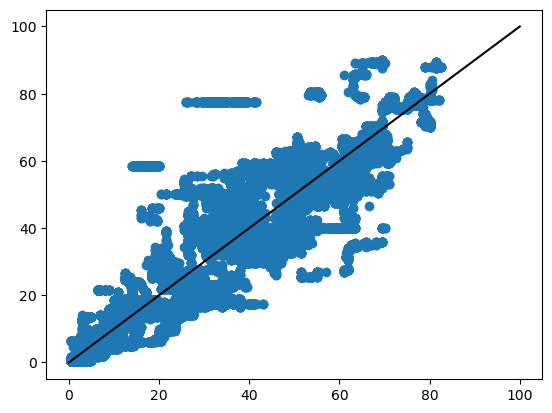

In [7]:
'''
if downwards momentum signal is present, expecting to see most of data fall below y=x line
'''

plt.figure()
plt.scatter(dw_x, dw_y)
plt.plot(np.linspace(0, 100, 10000), np.linspace(0, 100, 10000), color='black') 

In [13]:
'''
if downwards momentum signal is present, expecting to see most of data fall below y=x line
'''
def plot_downwards_mom_signal(x, y):
    plt.figure()
    plt.scatter(x, y)
    plt.plot(np.linspace(0, 100, 10000), np.linspace(0, 100, 10000), color='black') 
    plt.show()

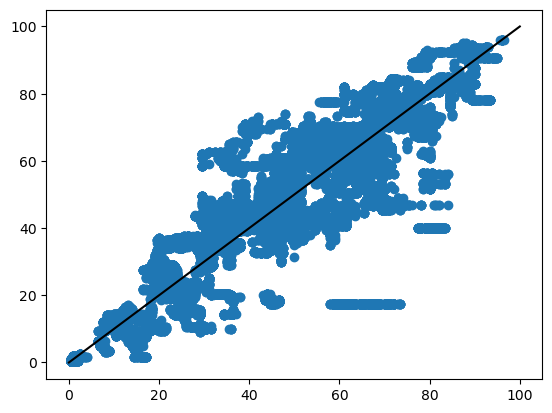

In [8]:
'''
if upwards momentum signal is present, expecting to see most of data fall above y=x line
'''
plt.figure()
plt.scatter(up_x, up_y)
plt.plot(np.linspace(0, 100, 10000), np.linspace(0, 100, 10000), color='black')

In [14]:
'''
if upwards momentum signal is present, expecting to see most of data fall above y=x line
'''

def plot_upwards_mom_signal(x, y):
    plt.figure()
    plt.scatter(x, y)
    plt.plot(np.linspace(0, 100, 10000), np.linspace(0, 100, 10000), color='black')
    plt.show()

initial plots don't support idea of the existence of momentum

In [11]:
list(ticker_df_dict.keys())

['INX-24JAN29-B4787',
 'INX-24JAN29-B4812',
 'INX-24JAN29-B4837',
 'INX-24JAN29-B4862',
 'INX-24JAN29-B4887',
 'INX-24JAN29-B4912',
 'INX-24JAN29-B4937',
 'INX-24JAN29-B4962',
 'INX-24JAN29-T4775',
 'INX-24JAN29-T4974.99',
 'NASDAQ100-24JAN29-B17150',
 'NASDAQ100-24JAN29-B17250',
 'NASDAQ100-24JAN29-B17350',
 'NASDAQ100-24JAN29-B17450',
 'NASDAQ100-24JAN29-B17550',
 'NASDAQ100-24JAN29-B17650',
 'NASDAQ100-24JAN29-B17750',
 'NASDAQ100-24JAN29-B17850',
 'NASDAQ100-24JAN29-T17100',
 'NASDAQ100-24JAN29-T17899.99',
 'INX-24JAN30-B4787',
 'INX-24JAN30-B4812',
 'INX-24JAN30-B4837',
 'INX-24JAN30-B4862',
 'INX-24JAN30-B4887',
 'INX-24JAN30-B4912',
 'INX-24JAN30-B4937',
 'INX-24JAN30-B4962',
 'INX-24JAN30-T4775',
 'INX-24JAN30-T4974.99',
 'NASDAQ100-24JAN30-B17050',
 'NASDAQ100-24JAN30-B17150',
 'NASDAQ100-24JAN30-B17250',
 'NASDAQ100-24JAN30-B17350',
 'NASDAQ100-24JAN30-B17450',
 'NASDAQ100-24JAN30-B17550',
 'NASDAQ100-24JAN30-B17650',
 'NASDAQ100-24JAN30-B17750',
 'NASDAQ100-24JAN30-T17000',


In [15]:
def return_mom_plot_points(ticker):

    dw_x = []
    dw_y = []
    up_x = []
    up_y = []

    for t, df in ticker_df_dict.items():
        
        if t != ticker:
            continue
            
        downwards_df = df[df['downwards_momentum_ind']==True]
        upwards_df = df[df['upwards_momentum_ind']==True]

        dw_x += downwards_df['midprice'].tolist()
        dw_y += downwards_df['future_midprice'].tolist()

        up_x += upwards_df['midprice'].tolist()
        up_y += upwards_df['future_midprice'].tolist()
    
    return dw_x, dw_y, up_x, up_y
    


In [38]:
dw_x, dw_y, up_x, up_y = return_mom_plot_points('INX-24JAN29-B4912')

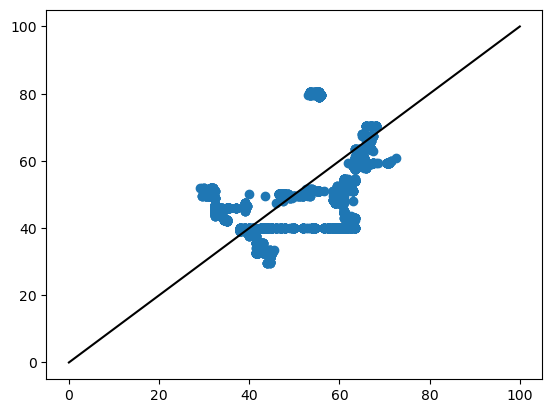

In [39]:
plot_downwards_mom_signal(dw_x, dw_y)

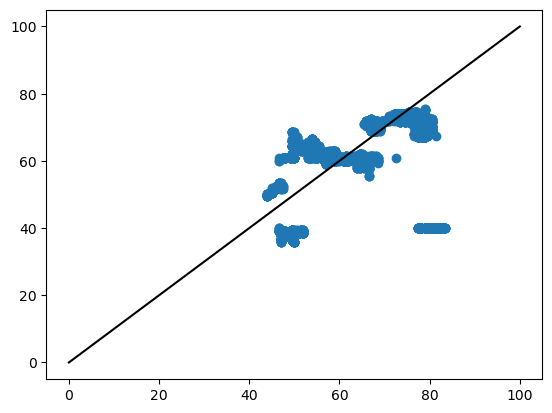

In [40]:
plot_upwards_mom_signal(up_x, up_y)

Some thoughts/ideas on how to modify this exploration/strategy:

-lookahead of the midprice 2.5 mins after signal is received is arbitary; try changing this and re-evaluating
-simple moving average over previous 5 mins may overrepresent prices at which multiple bids and offers are subimitted (ie: many deltas occuring at same price level will be overrepresented in sma); this will reduce variance arguably artificially 
-sma is less sensitive than ema. maybe try ema although ema will be more prone to noise
-maybe try using most recent 5-min interval return as a momentum signal instead
-instead of comparing a price to sma, maybe compare 2-min sma to 5-min sma instead or something like this 

Focus on prev 5 min returns

In [14]:
for t, df in ticker_df_dict.items():
    rets = []
    future_rets = []
    df['midprice'] = df.apply(func = lambda x: (x['best_bid'] + x['best_ask'])/2,axis=1)
    for idx, row in df.iterrows():
        cur_ts = row['timestamp'].to_pydatetime()
        beginning_interval = cur_ts - timedelta(seconds=90)
        beginning_idx = None
        before = df[(df['timestamp'] <= beginning_interval)].tail(1)
        df_avg = None
        if before.shape[0] > 0:
            ret = (row['midprice']-before['midprice'])/before['midprice']
        else:
            ret = (row['midprice']-df.iloc[0]['midprice'])/df.iloc[0]['midprice']
        rets.append(ret)
        
        beginning_interval = cur_ts + timedelta(seconds=90) 
        ahead = df[df['timestamp']>=beginning_interval].head(1)
        if ahead.shape[0] > 0:
            future_rets.append((ahead['midprice']-row['midprice'])/row['midprice'])
        else:
            future_rets.append((df.iloc[df.shape[0]-1]['midprice']-row['midprice'])/row['midprice'])
    df['past_return'] = rets   
    df['future_return'] = future_rets
    print(t)


INX-24JAN29-B4787
INX-24JAN29-B4812
INX-24JAN29-B4837
INX-24JAN29-B4862
INX-24JAN29-B4887
INX-24JAN29-B4912
INX-24JAN29-B4937
INX-24JAN29-B4962
INX-24JAN29-T4775
INX-24JAN29-T4974.99
NASDAQ100-24JAN29-B17150
NASDAQ100-24JAN29-B17250
NASDAQ100-24JAN29-B17350
NASDAQ100-24JAN29-B17450
NASDAQ100-24JAN29-B17550
NASDAQ100-24JAN29-B17650
NASDAQ100-24JAN29-B17750
NASDAQ100-24JAN29-B17850
NASDAQ100-24JAN29-T17100
NASDAQ100-24JAN29-T17899.99
INX-24JAN30-B4787
INX-24JAN30-B4812
INX-24JAN30-B4837
INX-24JAN30-B4862
INX-24JAN30-B4887
INX-24JAN30-B4912
INX-24JAN30-B4937
INX-24JAN30-B4962
INX-24JAN30-T4775
INX-24JAN30-T4974.99
NASDAQ100-24JAN30-B17050
NASDAQ100-24JAN30-B17150
NASDAQ100-24JAN30-B17250
NASDAQ100-24JAN30-B17350


/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_69687/2282088936.py:22: RuntimeWarning: invalid value encountered in double_scalars
  future_rets.append((df.iloc[df.shape[0]-1]['midprice']-row['midprice'])/row['midprice'])


NASDAQ100-24JAN30-B17450
NASDAQ100-24JAN30-B17550
NASDAQ100-24JAN30-B17650
NASDAQ100-24JAN30-B17750
NASDAQ100-24JAN30-T17000
NASDAQ100-24JAN30-T17799.99
INX-24JAN31-B4837
INX-24JAN31-B4862
INX-24JAN31-B4887
INX-24JAN31-B4912
INX-24JAN31-B4937
INX-24JAN31-B4962
INX-24JAN31-B4987
INX-24JAN31-B5012
INX-24JAN31-T4825
INX-24JAN31-T5024.99
NASDAQ100-24JAN31-B17150
NASDAQ100-24JAN31-B17250
NASDAQ100-24JAN31-B17350
NASDAQ100-24JAN31-B17450
NASDAQ100-24JAN31-B17550
NASDAQ100-24JAN31-B17650
NASDAQ100-24JAN31-B17750
NASDAQ100-24JAN31-B17850
NASDAQ100-24JAN31-T17100
NASDAQ100-24JAN31-T17899.99


In [18]:
def get_returns(ticker=None):
    past_rets = []
    future_rets = []

    for t, df in ticker_df_dict.items():
        if ticker is None:
            past_rets += df['past_return'].tolist()
            future_rets += df['future_return'].tolist()
        elif ticker == t:
            past_rets += df['past_return'].tolist()
            future_rets += df['future_return'].tolist()
            break
    return past_rets, future_rets

In [48]:
def plot_past_and_fut_returns(ticker, past, fut):
    plt.figure()
    plt.scatter(past, fut)
    plt.plot(np.linspace(-1, 1, 10000), np.linspace(-1, 1, 10000), color='black')
    plt.title(ticker)
    plt.show()

/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


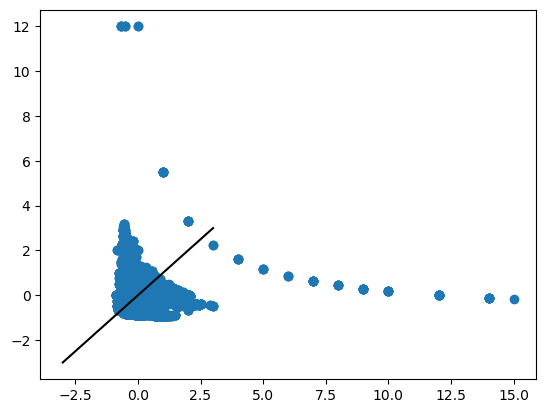

In [19]:
x, y = get_returns()
plot_past_and_fut_returns(x, y)

In [21]:
ticker_df_dict.keys()

dict_keys(['INX-24JAN29-B4787', 'INX-24JAN29-B4812', 'INX-24JAN29-B4837', 'INX-24JAN29-B4862', 'INX-24JAN29-B4887', 'INX-24JAN29-B4912', 'INX-24JAN29-B4937', 'INX-24JAN29-B4962', 'INX-24JAN29-T4775', 'INX-24JAN29-T4974.99', 'NASDAQ100-24JAN29-B17150', 'NASDAQ100-24JAN29-B17250', 'NASDAQ100-24JAN29-B17350', 'NASDAQ100-24JAN29-B17450', 'NASDAQ100-24JAN29-B17550', 'NASDAQ100-24JAN29-B17650', 'NASDAQ100-24JAN29-B17750', 'NASDAQ100-24JAN29-B17850', 'NASDAQ100-24JAN29-T17100', 'NASDAQ100-24JAN29-T17899.99', 'INX-24JAN30-B4787', 'INX-24JAN30-B4812', 'INX-24JAN30-B4837', 'INX-24JAN30-B4862', 'INX-24JAN30-B4887', 'INX-24JAN30-B4912', 'INX-24JAN30-B4937', 'INX-24JAN30-B4962', 'INX-24JAN30-T4775', 'INX-24JAN30-T4974.99', 'NASDAQ100-24JAN30-B17050', 'NASDAQ100-24JAN30-B17150', 'NASDAQ100-24JAN30-B17250', 'NASDAQ100-24JAN30-B17350', 'NASDAQ100-24JAN30-B17450', 'NASDAQ100-24JAN30-B17550', 'NASDAQ100-24JAN30-B17650', 'NASDAQ100-24JAN30-B17750', 'NASDAQ100-24JAN30-T17000', 'NASDAQ100-24JAN30-T17799.99

In [62]:
ticker_df_dict['NASDAQ100-24JAN30-B17150']

,hour,minute,best_bid,best_ask,ticker,timestamp,midprice,1min_return
0,20,15,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:15:48.244708,0.5,0.0
1,20,25,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:25:31.295784,0.5,0.0
2,20,33,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:33:27.342637,0.5,0.0
3,20,43,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:43:25.323560,0.5,0.0
4,20,44,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:44:55.377859,0.5,0.0
5,20,51,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:51:16.320248,0.5,0.0
6,20,53,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:53:01.357320,0.5,0.0
7,20,55,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:55:10.501887,0.5,0.0
8,20,57,0,1.0,NASDAQ100-24JAN30-B17150,2024-01-30 20:57:03.420690,0.5,0.0


In [28]:
for t, df in ticker_df_dict.items():
    df = df.drop(columns='past_return').drop(columns='future_return')
    ticker_df_dict[t] = df

In [52]:
for t, df in ticker_df_dict.items():
    df['hour'] = df.apply(func = lambda x: x['timestamp'].hour, axis=1)
    df['minute'] = df.apply(func = lambda x: x['timestamp'].minute, axis=1)
    df['midprice'] = df.apply(func = lambda x: (x['best_bid'] + x['best_ask'])/2, axis=1)

In [53]:
for t, df in ticker_df_dict.items():
    ticker_df_dict[t] = df.groupby(['hour', 'minute']).first().reset_index()

In [54]:
for t, df in ticker_df_dict.items():
    midprices = df['midprice'].to_numpy()
    returns = (midprices[1:]-midprices[:-1])/midprices[:-1]
    df['1min_return'] = list(returns) + [None]

In [55]:
for t, df in ticker_df_dict.items():
    ticker_df_dict[t] = df.iloc[:-1]

In [64]:
for t, df in ticker_df_dict.items():
    if df['1min_return'].unique().tolist()[0] == 0:
        continue
    x = df[df['minute']>=45]['1min_return'].iloc[:-1].tolist()
    y = df[df['minute']>=45]['1min_return'].iloc[1:].tolist()
    print(t, np.corrcoef(x,y)[0,1], sep=', ')
    
    

INX-24JAN29-B4887, nan
INX-24JAN29-B4912, -0.5173436664237637
INX-24JAN29-B4937, -0.525314316117621
NASDAQ100-24JAN29-B17450, -0.4999999999999999
NASDAQ100-24JAN29-B17650, -0.37423280520741564
INX-24JAN30-B4937, 0.34996833262142374
NASDAQ100-24JAN30-B17450, 0.02490384728518074
NASDAQ100-24JAN30-B17550, 0.24915597291673638
INX-24JAN31-B4837, -0.6617387173415856


/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


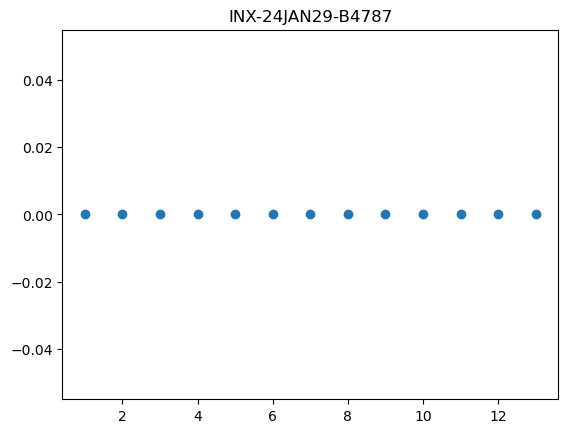

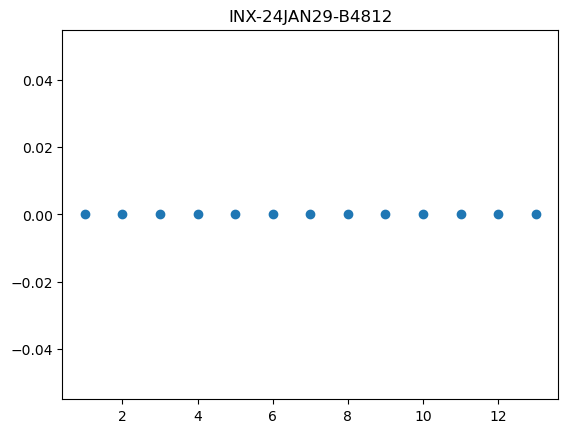

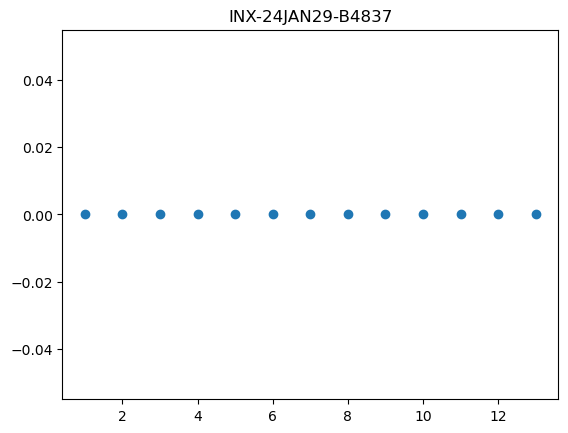

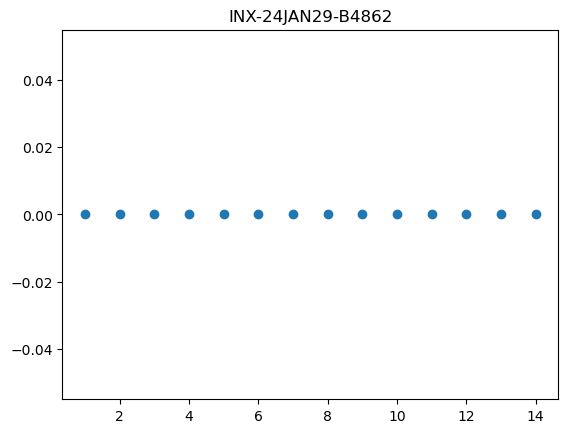

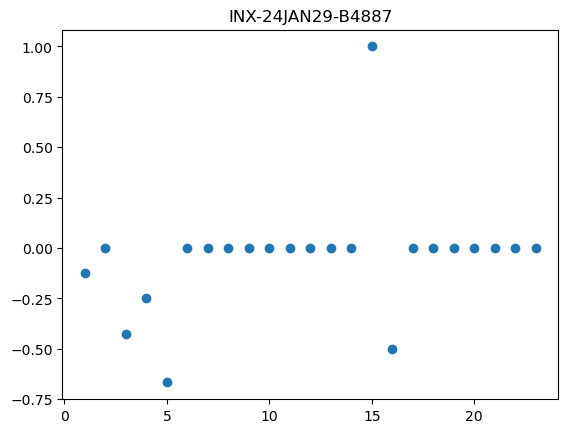

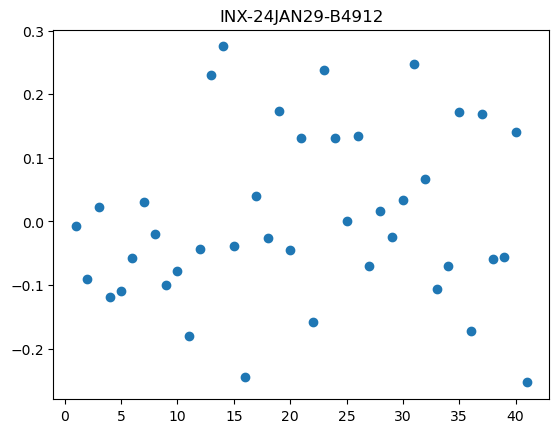

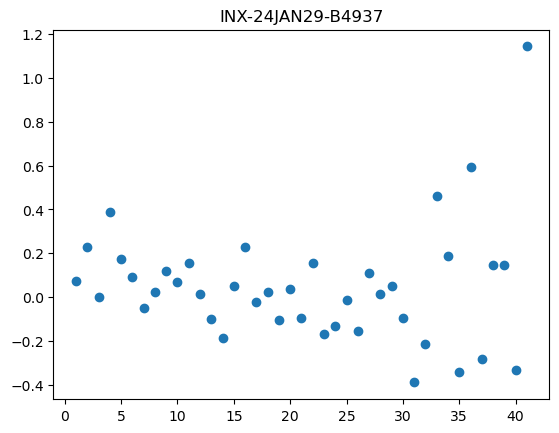

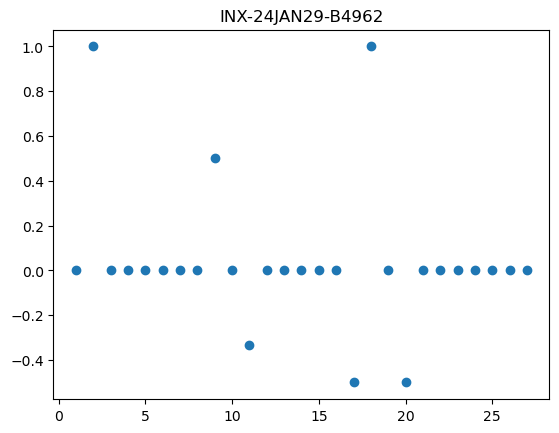

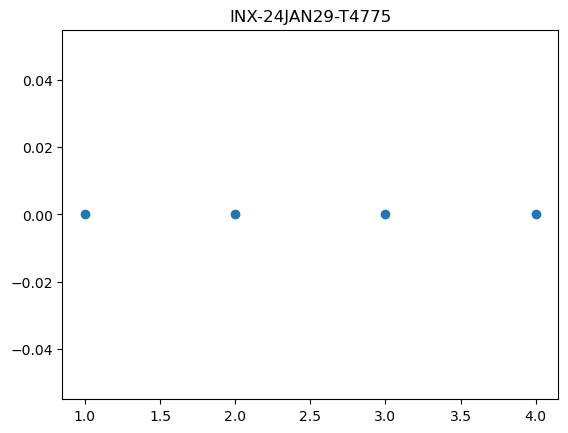

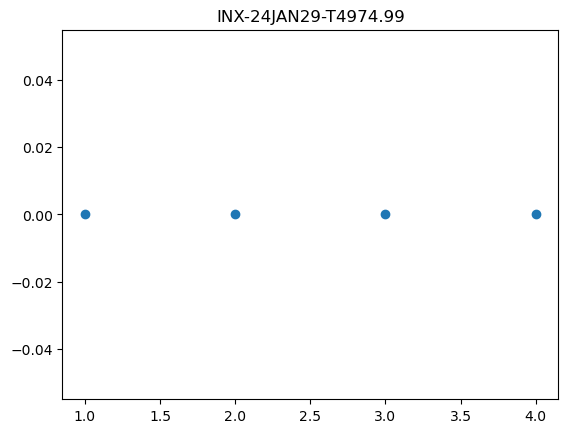

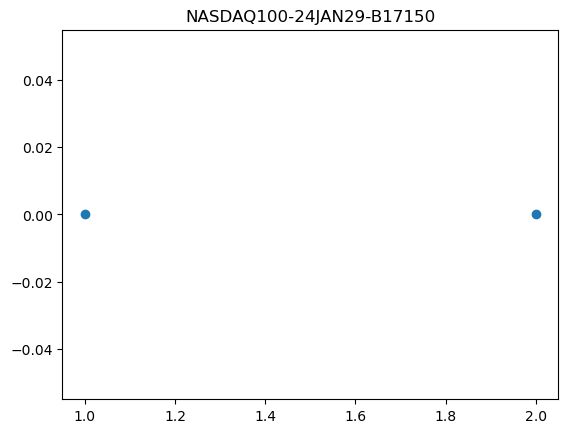

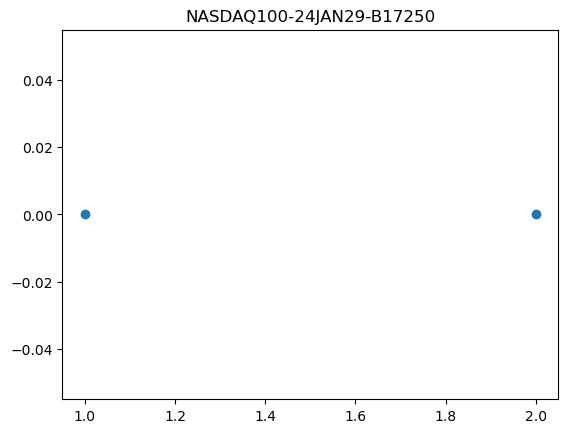

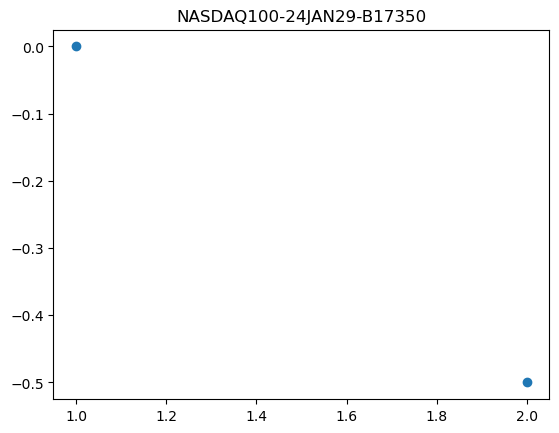

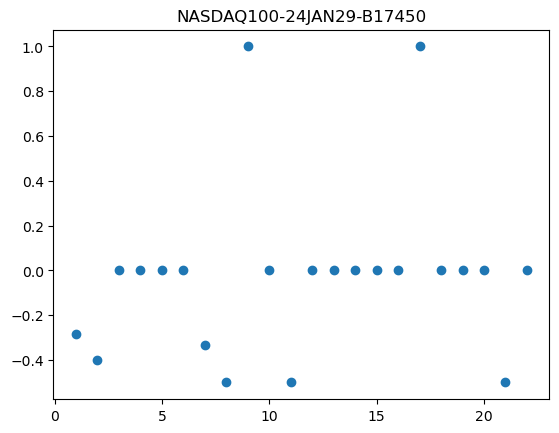

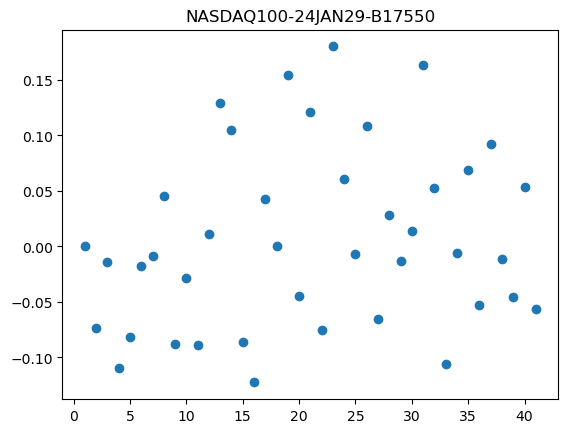

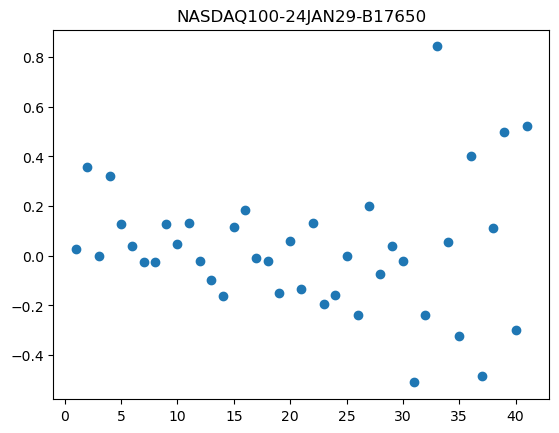

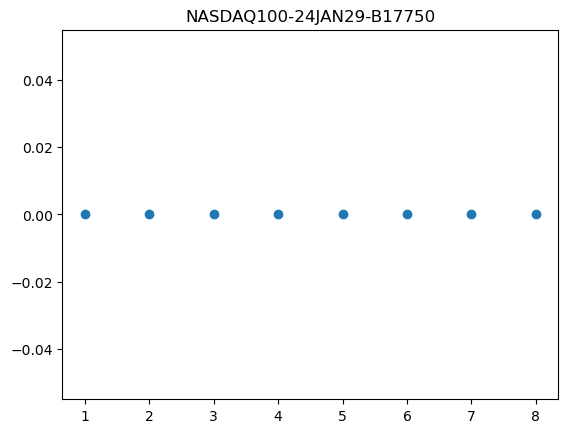

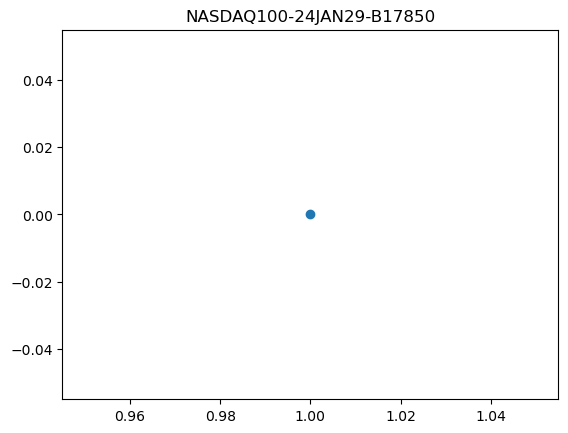

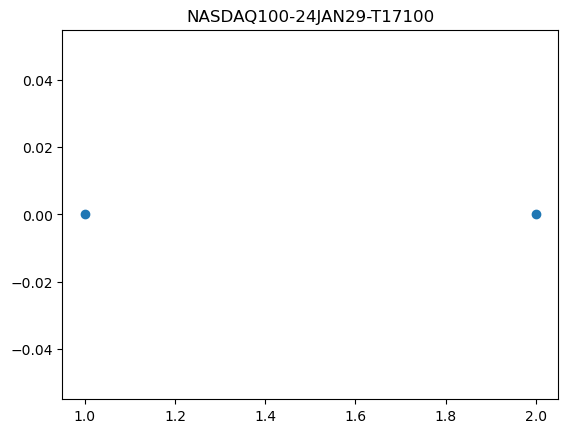

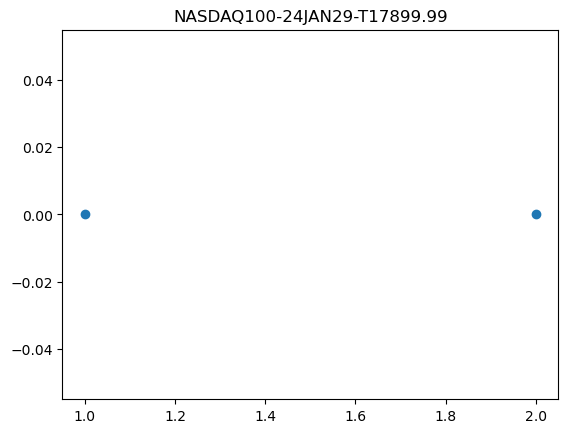

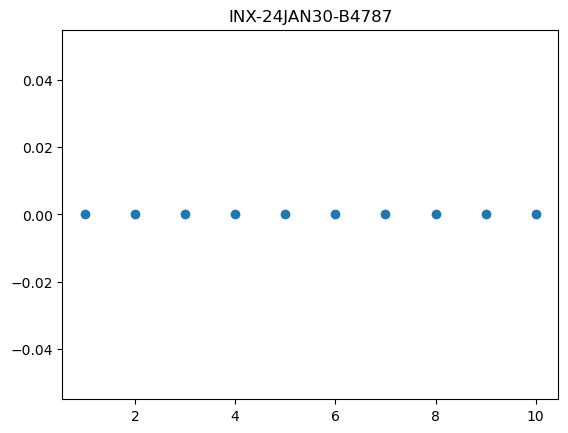

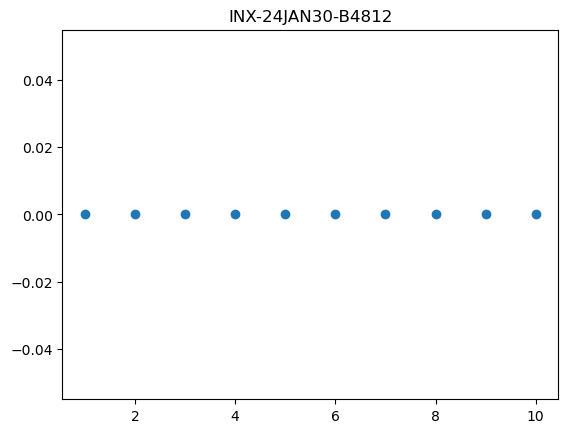

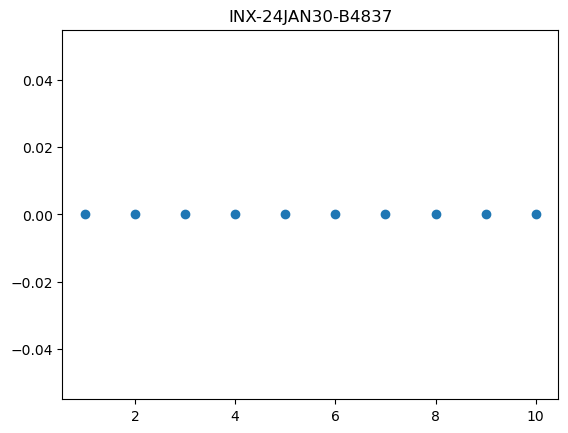

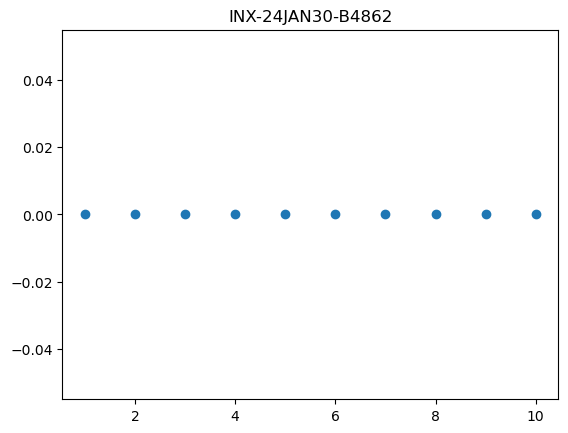

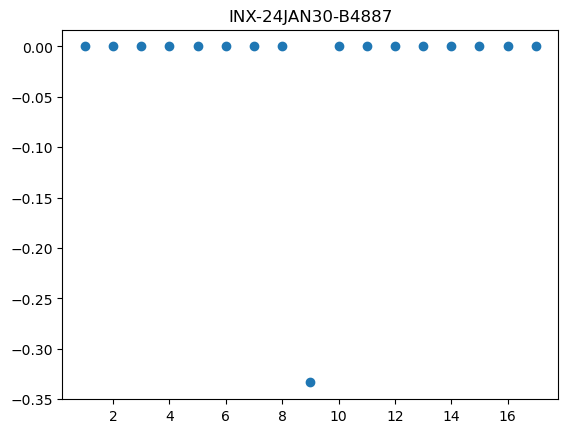

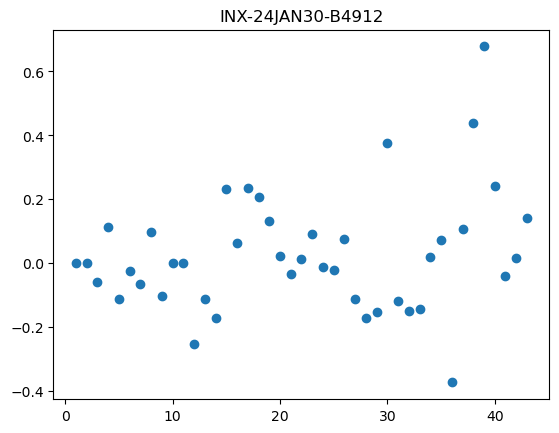

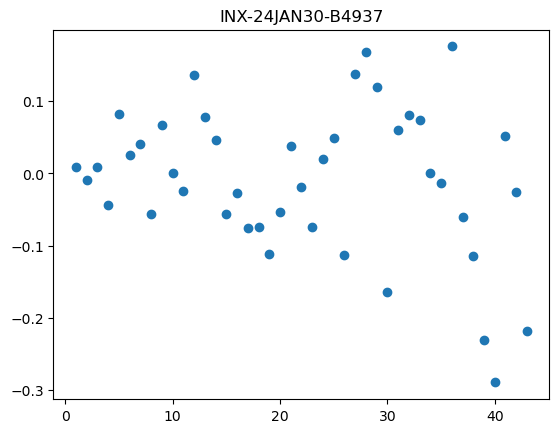

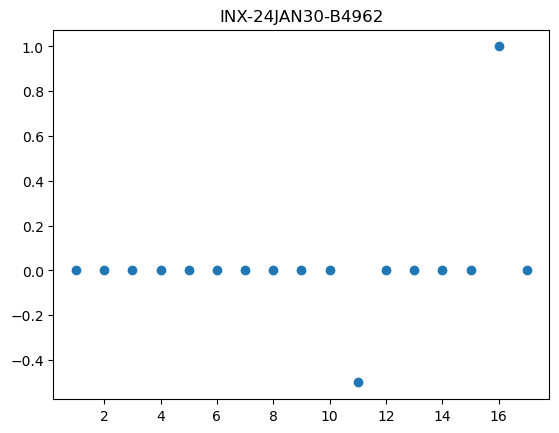

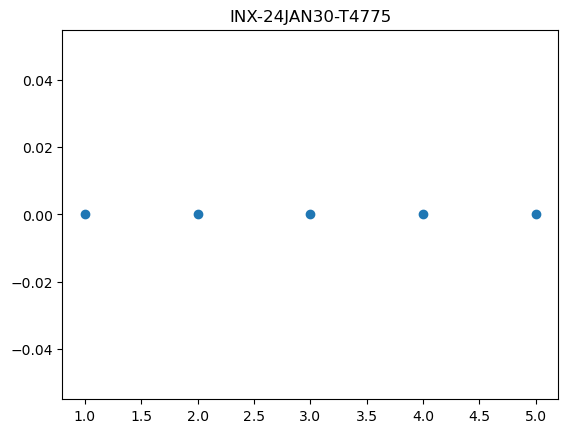

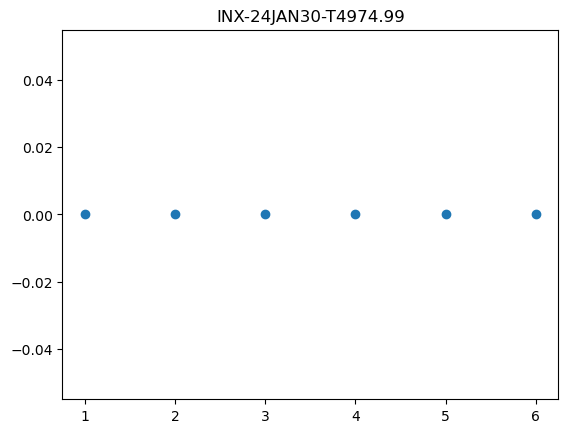

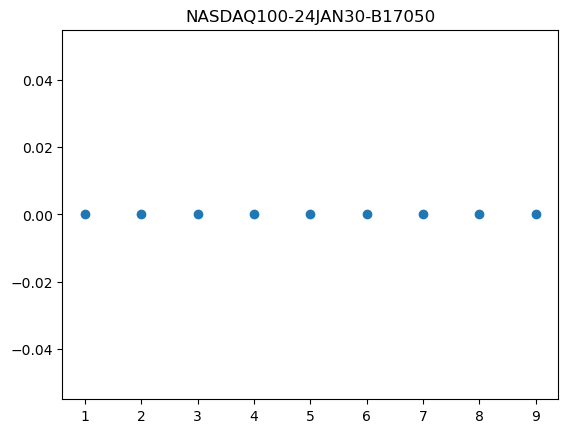

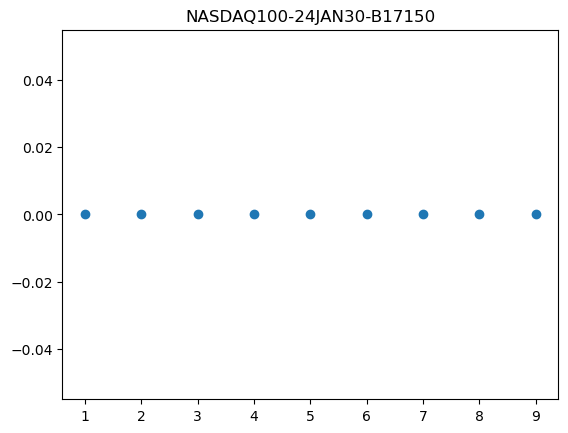

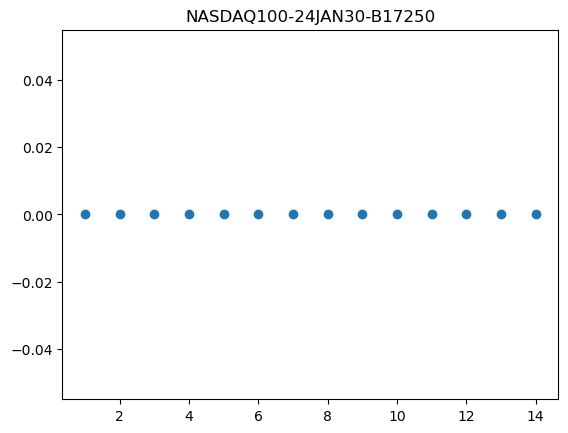

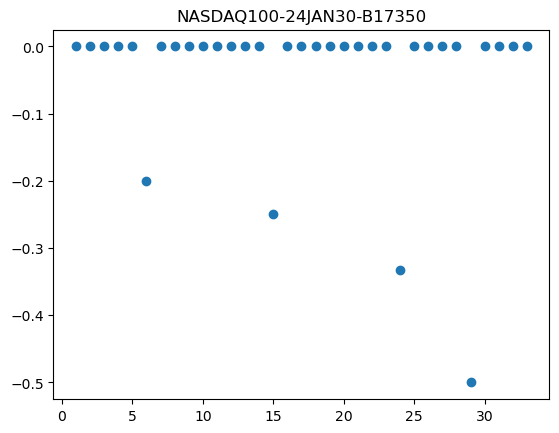

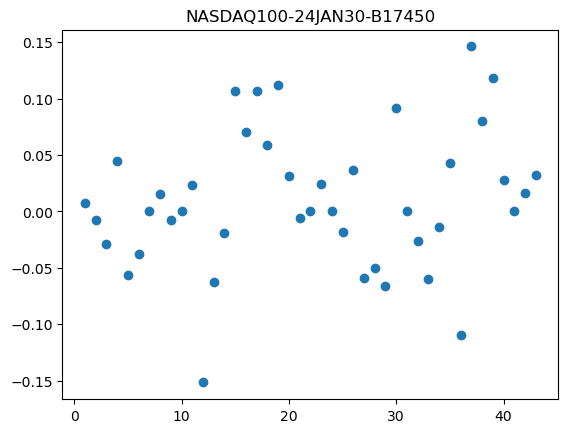

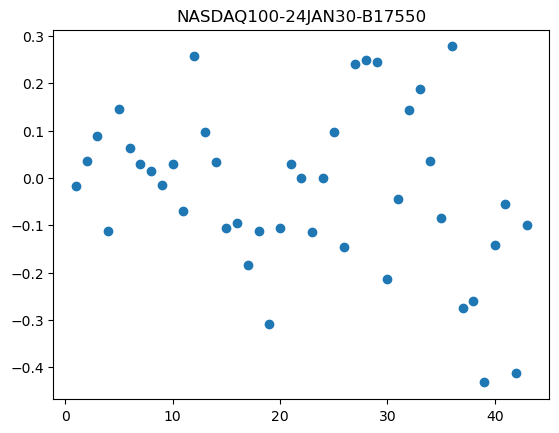

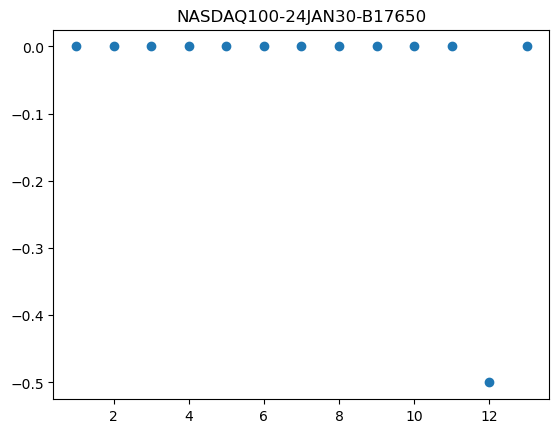

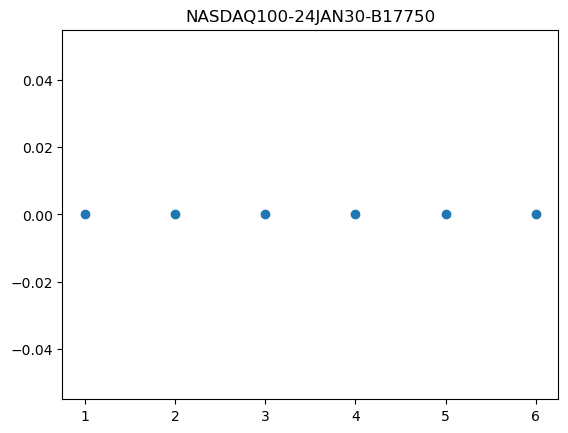

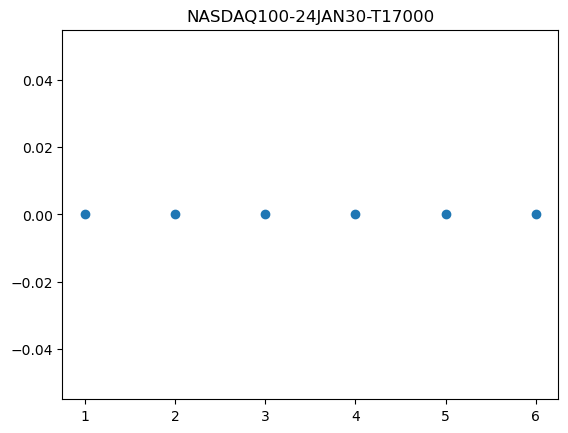

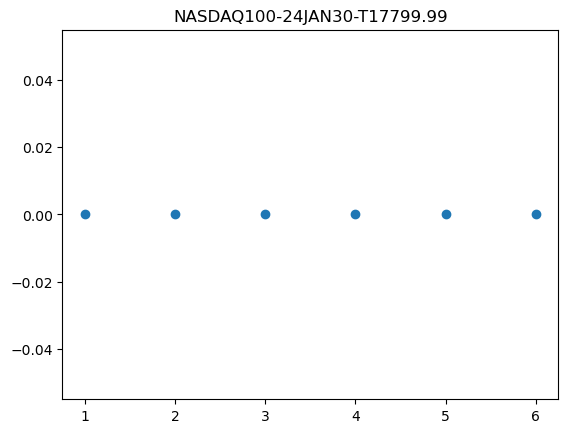

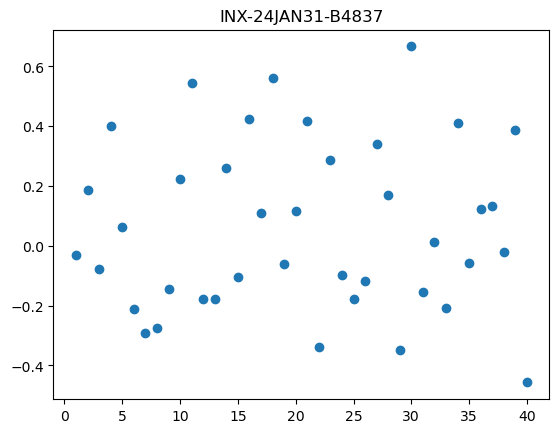

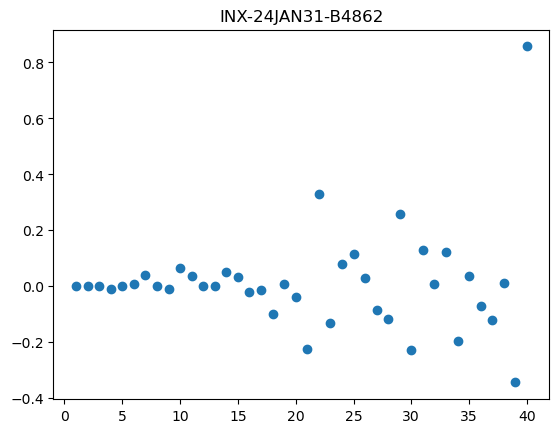

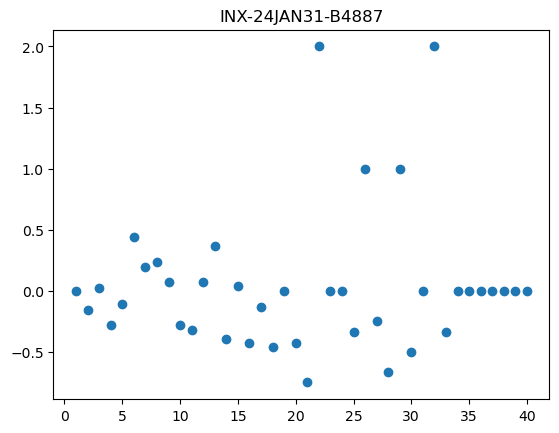

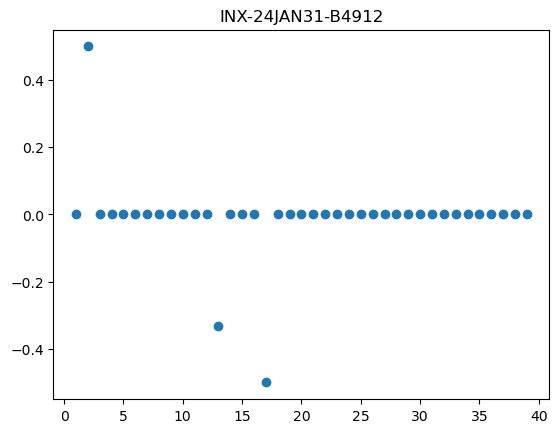

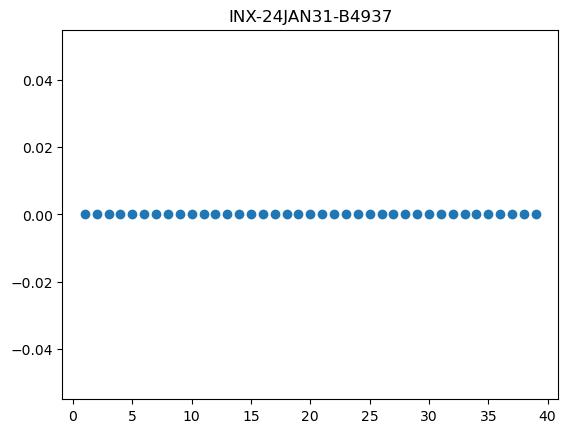

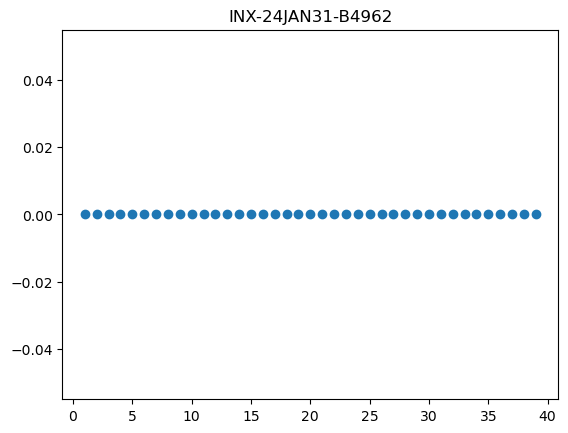

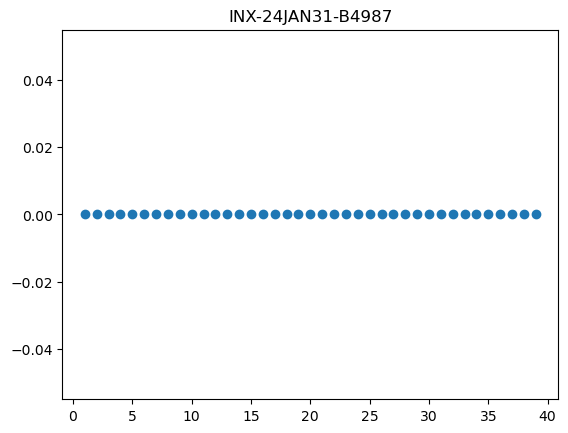

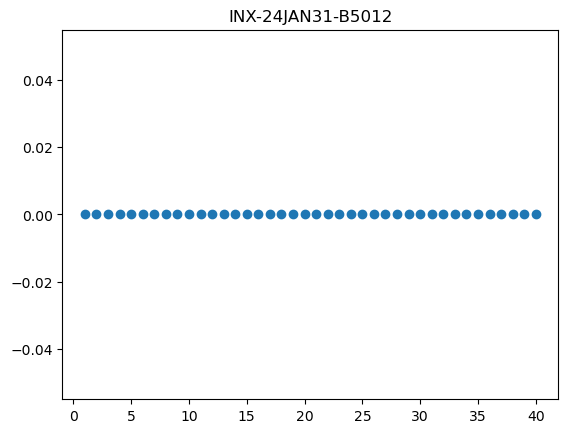

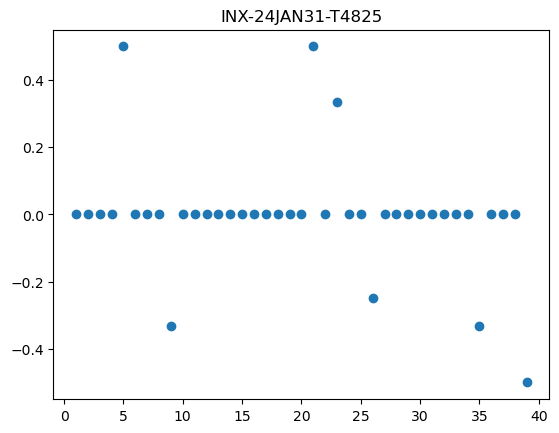

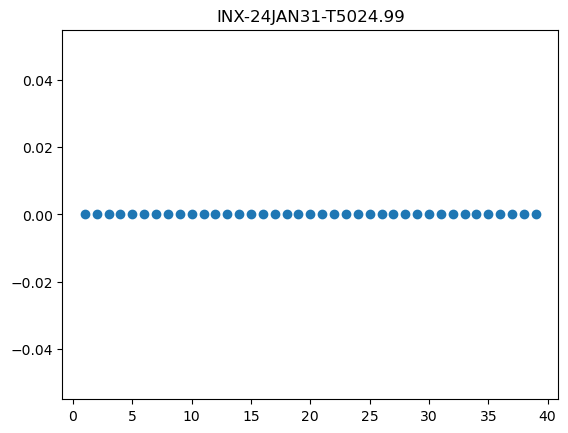

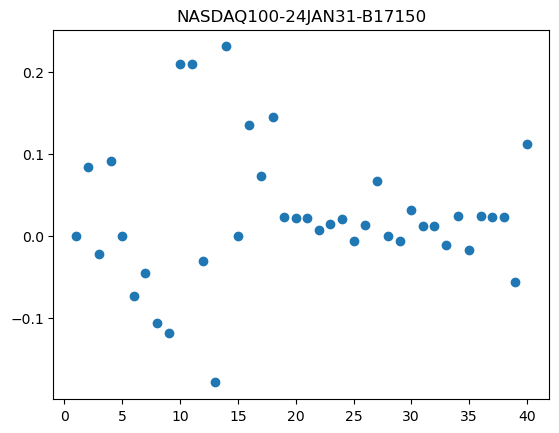

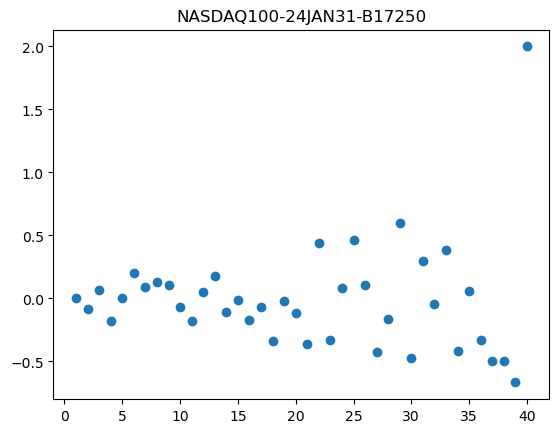

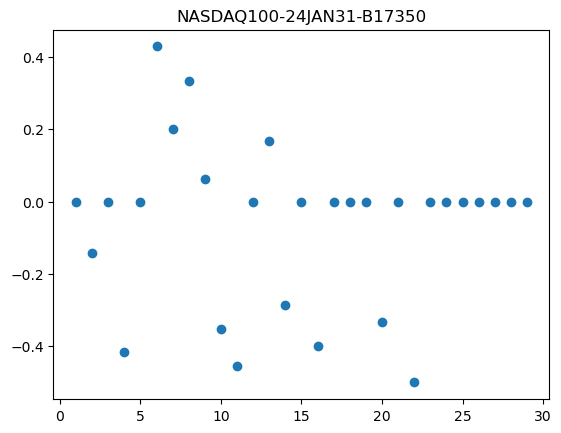

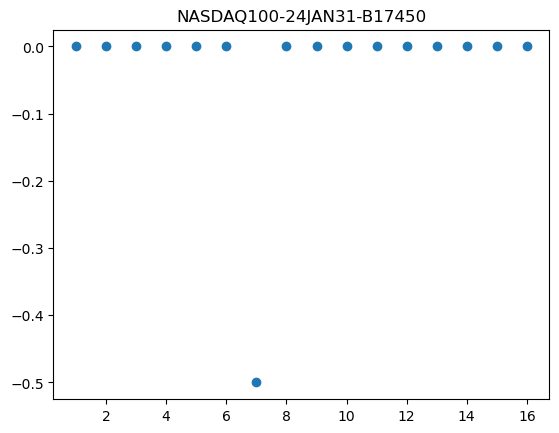

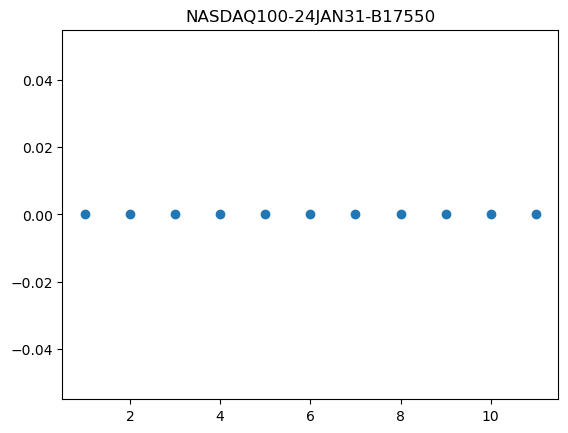

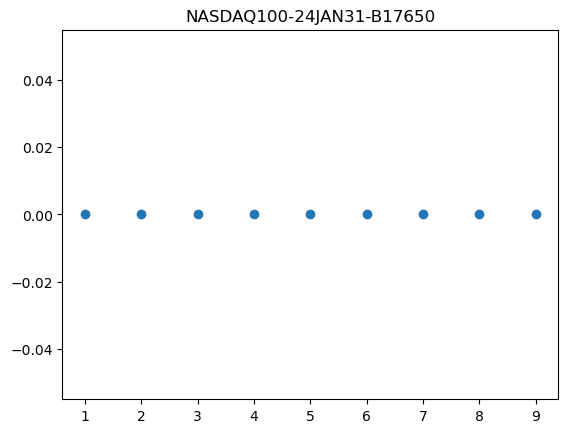

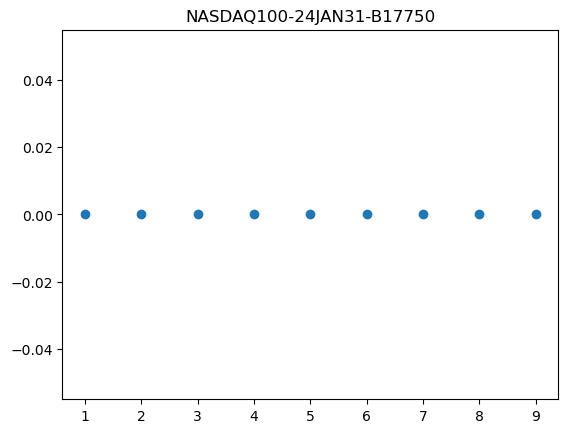

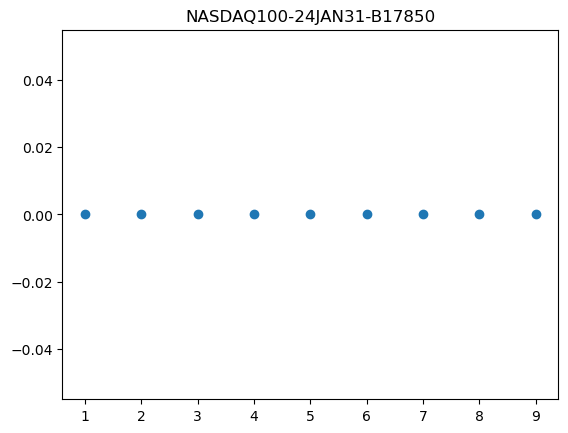

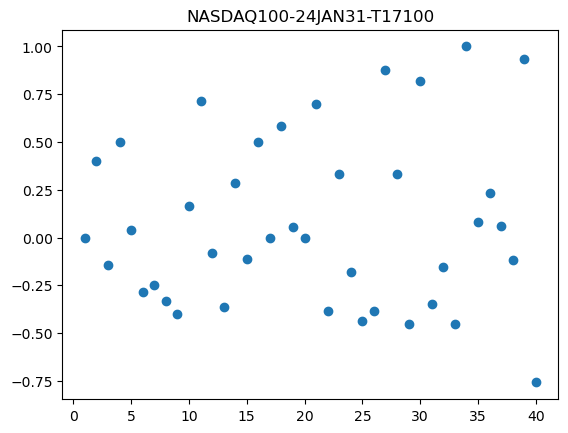

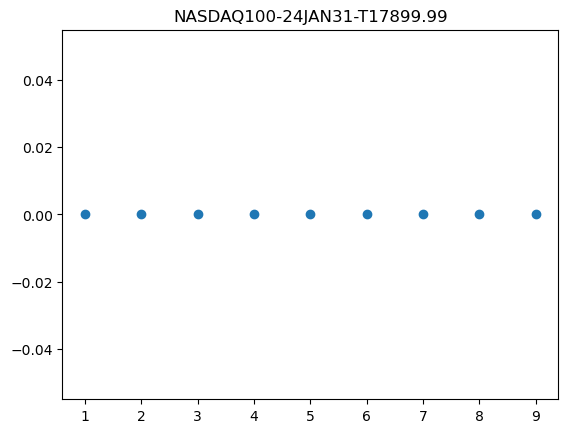

In [66]:
for t, df in ticker_df_dict.items():
    plt.figure()
    plt.scatter(np.linspace(1,df.shape[0],df.shape[0]), df['1min_return'])
    plt.title(t)
    plt.show()
    